In [6]:
import numpy as np
import pandas as pd
from CHEM274.importer_snippets import load_experiment
from scipy.signal import find_peaks, savgol_filter
from LinReg import PolyReg
import matplotlib.pyplot as plt
plt.style.use('JGW-PPT')
import os
os.getcwd()

'C:\\Users\\jgage\\Documents\\GitHub\\CHEM274\\CV-fitting'

In [7]:
def save_CV_fig(experiment, fig, analyte, electrode, solvent, notebook):
    ans = input('Save the figure?')
    if ans in ['y', 'yes', 'Yes', 'yeye', 'yeah', 'why, certainly', True]:
        fig.savefig(r"C:\\Users\\jgage\\Documents\GitHub\\CHEM274\\data\\figs\\CV_"+
                    analyte + electrode + solvent +
                    str(experiment.params.loc[experiment.params['parameter']=='scan_rate', 'value'].item()) + 'Vs-1_'+
                    notebook+'.jpg')
        print('Saved')
    else:
        print('Not saved')

In [11]:
# Import Data
exp100 = load_experiment(csv_dirname=r"..\data\CV_Fc_GC_mix_0.1Vs-1_P-08-13")
exp80 = load_experiment(csv_dirname=r"..\data\CV_Fc_GC_mix_0.08Vs-1_P-08-14")
exp60 = load_experiment(csv_dirname=r"..\data\CV_Fc_GC_mix_0.06Vs-1_P-08-15")
exp40 = load_experiment(csv_dirname=r"..\data\CV_Fc_GC_mix_0.04Vs-1_P-08-16")


exp_series = [exp100, exp80, exp60, exp40]

In [12]:
# These data were taken week 3 and do not need referance calibration.
# CV.data['Ecell'] = CV.data['Ecell'] - 0.094010
exp100.data

,E_program,Ecell,iw,t
0,0.000000,0.001581,-7.204973e-07,0.000000
1,0.000000,0.000595,-7.204973e-07,0.000278
2,0.000000,0.000924,-1.707063e-06,0.000556
3,0.000000,0.000595,-1.049353e-06,0.000833
4,0.000000,0.000595,-7.204973e-07,0.001111
...,...,...,...,...
79195,0.000111,0.000924,-3.022484e-06,21.998611
79196,0.000083,0.000595,-3.351339e-06,21.998889
79197,0.000056,0.000924,-3.680195e-06,21.999167
79198,0.000028,0.000595,-2.693629e-06,21.999444


C:\Users\jgage\AppData\Local\Temp/ipykernel_21340/2827646243.py:16: PeakPropertyWarning: some peaks have a width of 0
  find_ipa = find_peaks(exp.data['savgol_iw'], height=0, width=3600) # Must give minimum height to get peak_heights dict.
C:\Users\jgage\AppData\Local\Temp/ipykernel_21340/2827646243.py:16: PeakPropertyWarning: some peaks have a width of 0
  find_ipa = find_peaks(exp.data['savgol_iw'], height=0, width=3600) # Must give minimum height to get peak_heights dict.


{'ipa': 2.9205332162144892e-05, 'Epa': 0.44096262080944, 'ipc': -1.847868081459369e-05, 'Epc': 0.3564944426470481}
{'ipa': 2.5259068830761484e-05, 'Epa': 0.43071416144936275, 'ipc': -1.683440458771712e-05, 'Epc': 0.3509088297468379}
{'ipa': 2.1970516080589987e-05, 'Epa': 0.42480462400794133, 'ipc': -1.4532417860170149e-05, 'Epc': 0.353480808342307}
{'ipa': 1.802425281156174e-05, 'Epa': 0.4313278027745959, 'ipc': -1.0915010122070968e-05, 'Epc': 0.3592137463435009}


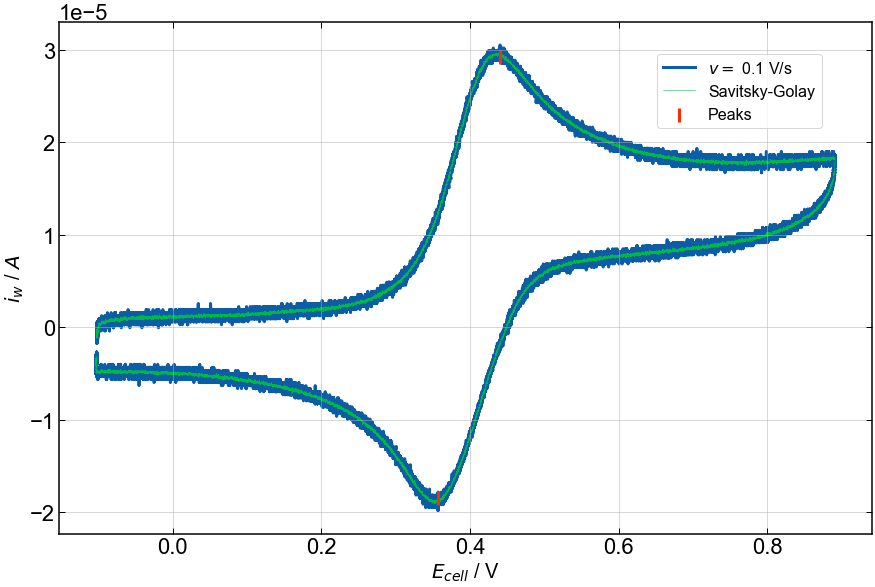

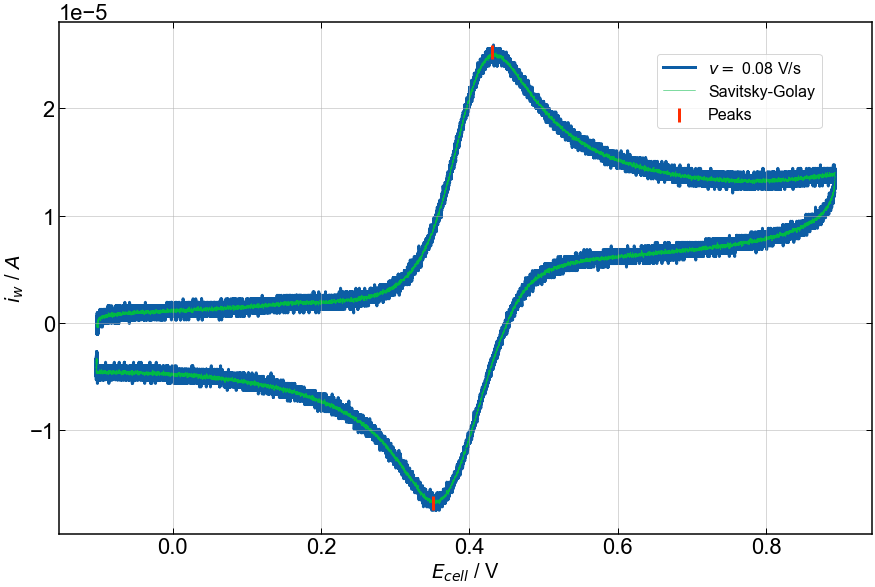

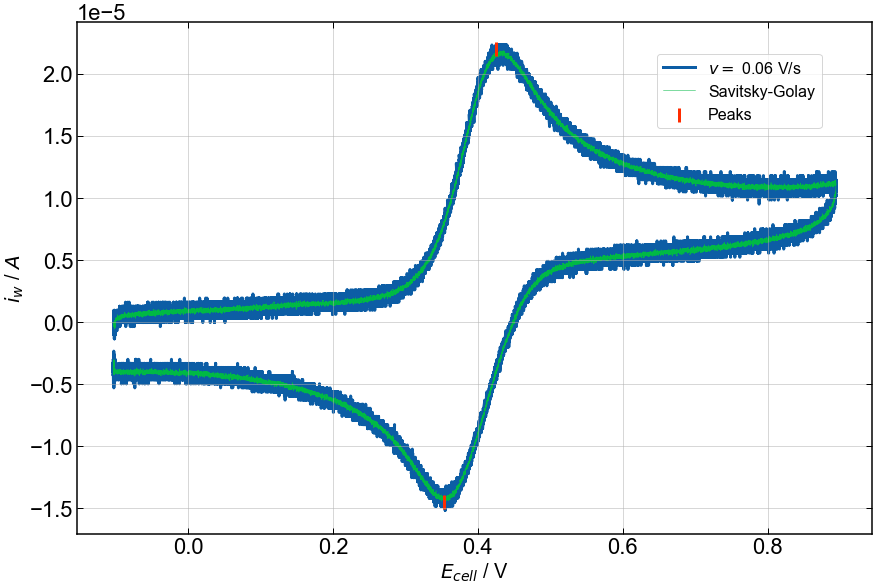

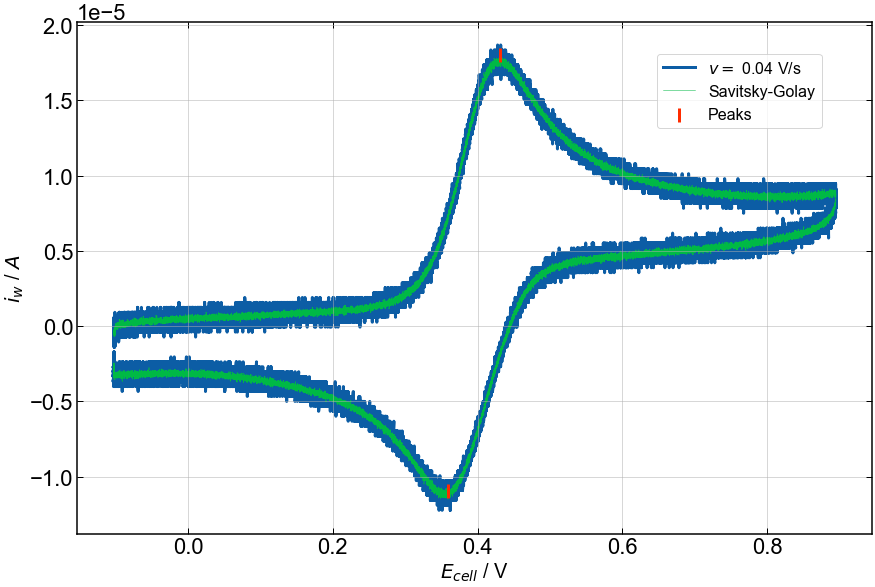

In [13]:
i = 0 # for setting savenames
picked_peaks = []
for exp in exp_series:
    # Reference Calibration
    exp.data['Ecell'] = exp.data['Ecell'] - 0.101984


    # Apply iR correction for Ru determined by EIS fitting to the Randles circuit
    Ru = 4.03e+02 # Ohms
    exp.data['Ecell'] = exp.data['Ecell'] - Ru * exp.data['iw'].abs() # 100% Compensation!

    # Smooth data using the Savitski Golay method
    exp.data['savgol_iw'] = savgol_filter(exp.data['iw'], 25, 2)

    # Maxima
    find_ipa = find_peaks(exp.data['savgol_iw'], height=0, width=3600) # Must give minimum height to get peak_heights dict.
    ipa, Epa = exp.data['iw'][find_ipa[0]].to_numpy(), exp.data['Ecell'][find_ipa[0]].to_numpy()

    # Invert signal to find minima - Signals are negative but indices are correct!
    find_ipc = find_peaks(-exp.data['savgol_iw'], height=0, width=3600) # Remember to un-invert anytime if calling ipc values from find_ipc, but not indicies.
    ipc, Epc = exp.data['iw'][find_ipc[0]].to_numpy(), exp.data['Ecell'][find_ipc[0]].to_numpy()

    peaks = {'ipa': ipa[0], 'Epa': Epa[0], 'ipc': ipc[0], 'Epc': Epc[0]}
    picked_peaks.append(pd.DataFrame(data=peaks, index=[0])) # Gives a little table, but rounds values...
    print(peaks)


    # Now some plotting
    fig = plt.figure()
    ax = fig.add_subplot()

    ax.tick_params(axis='both', which='both', direction='in', right=True, top=True)
    ax.plot(exp.data['Ecell'], exp.data['iw'], label = '$v=$ '+str(exp.params.loc[exp.params['parameter']=='scan_rate', 'value'].item()) + ' V/s', zorder=0)
    ax.plot(exp.data['Ecell'], exp.data['savgol_iw'], color='C2', label='Savitsky-Golay', lw=.5, zorder=.5)
    ax.scatter([*Epa, *Epc], [*ipa, *ipc], color='C1', label='Peaks', marker='|', s=200, zorder=1)
    fig.tight_layout()

    ax.set_xlabel('$E_{cell}$ / V')
    ax.set_ylabel('$i_{w}$ / $A$')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    fig.legend(loc=(0.75, 0.78))

    analyte = 'Fc_'
    electrode = 'GC_'
    solvent = 'mix'
    notebook = ['_P-08-13', '_P-08-14', '_P-08-15', '_P-08-16']

    # plt.show()
    # save_CV_fig(exp, fig, analyte, electrode, solvent, notebook[i])

    i += 1

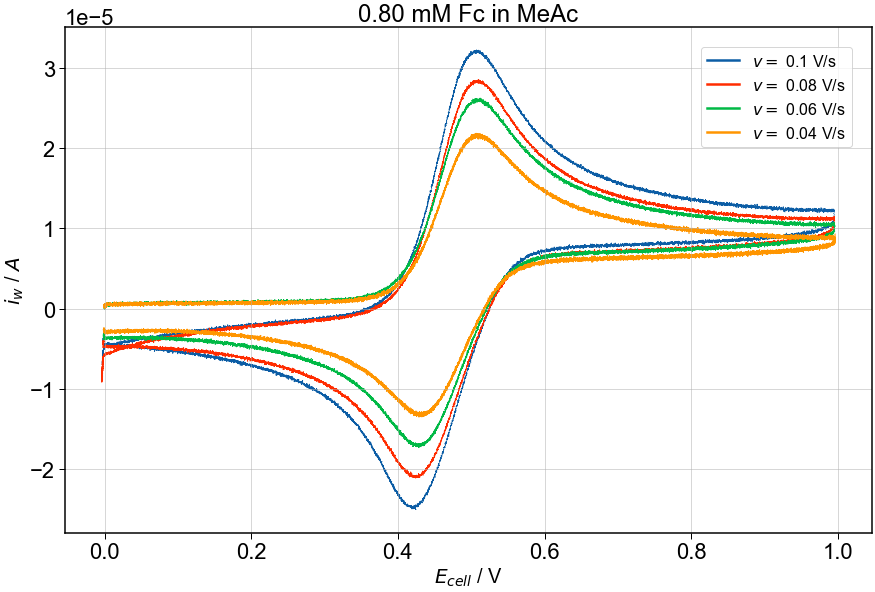

In [46]:
fig = plt.figure()
ax = fig.add_subplot()

for exp in exp_series:
    ax.plot(exp.data['Ecell'], exp.data['savgol_iw'],
            label='$v=$ '+str(exp.params.loc[exp.params['parameter']=='scan_rate', 'value'].item()) + ' V/s',
            lw=.5, zorder=.5)

fig.tight_layout()

ax.set_xlabel('$E_{cell}$ / V')
ax.set_ylabel('$i_{w}$ / $A$')
ax.set_title('0.80 mM Fc in MeAc')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
leg = fig.legend(loc=(0.80, 0.75))

for line in leg.get_lines():
    line.set_linewidth(2.5)

coef_deg1       1.677678e-04
std_err_deg1    1.709308e-05
coef_deg0       1.541042e-05
std_err_deg0    1.256080e-06
r_squared       9.796610e-01
s_y             7.644257e-07
dtype: float64

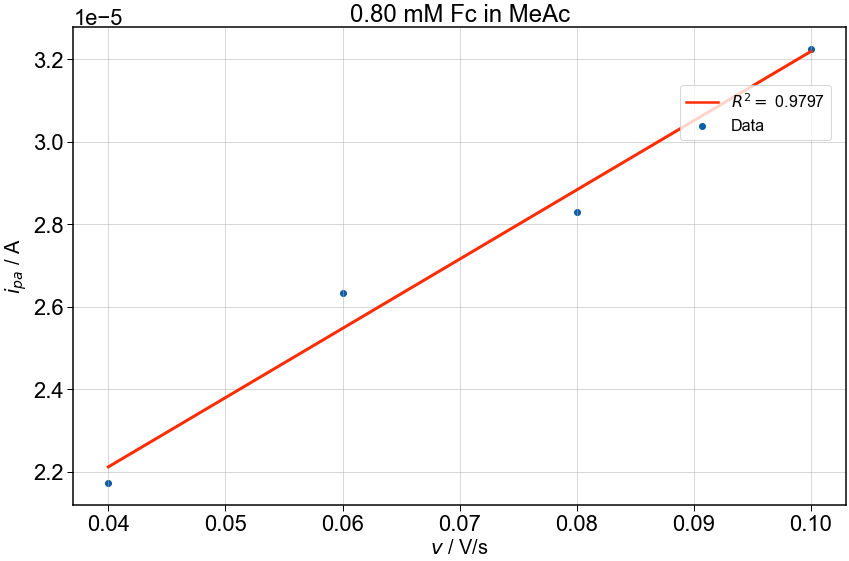

In [56]:
# Hey, actually you should fix b=0, which is not an existing functionality in PolyReg.

x, y = [], []
for i in range(len(exp_series)):
    x.append(exp_series[i].params.loc[exp_series[i].params['parameter']=='scan_rate', 'value'].item())
    y.append(picked_peaks[i]['ipa'].item())

fit = PolyReg(x, y, 1)

fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(x, y, label='Data', c='C0')
ax.plot(x, fit.eval(x), label='$R^2 =$ '+ '{:.4f}'.format(fit.r_squared), c='C1')

ax.set_xlabel('$v$ / V/s')
ax.set_ylabel('$i_{pa}$ / A')
ax.set_title('0.80 mM Fc in MeAc')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax.set_xlim(0, np.max(x)*1.1)
ax.set_ylim(0, np.max(y)*1.1)

fig.tight_layout()

leg = fig.legend(loc=(0.80, 0.75))
for line in leg.get_lines():
    line.set_linewidth(2.5)

fit.report()